# The RegressionModel

In the last few notebooks we discussed modern deep learning techniques for time series forecasting like Transformer models and N-BEATS. With the release of `darts 0.7.0` we extended our support for (mostly) classical models following the scikit-learn API.
The `RegressionModel` enables you to transform any model having a `.fit()` and `.predict()` method (including most models of scikit-learn and `darts`) into an autoregressive model using the lags of the endogenous and exogeneous variables to forecast values of the target time series. In this notebook you will see how easy it is to use the `RegressionModel` and how you can get the best out of your "classical" time series models.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####### Will be removed on merge
sys.path.insert(0, os.path.abspath('../'))
####### Will be removed on merge

from darts import TimeSeries
from darts.metrics import mape, smape, rmse
from darts.models import RegressionModel, LinearRegressionModel, RandomForest
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, HuberRegressor

np.random.seed(1) 

Importing plotly failed. Interactive plots will not work.


## Load data without exogenous variables

First we are going to read the data, in this case the AirPassenger dataset and split the series (as usual) into a training and testing series by specifying a fraction of the data `darts` should reserve for traing. We choose here that 70% of the data should be used for training and 30% should be held out for evaluation purposes. 

We also before the differencing operation to remove the trend from the time series which is required for some models. For example the `RandomForest` model (as well as other tree-based algorithms) performs very badly on trending time series as they can not predict values beyond the range of the training series (most of the time they compute the mean on the leafe level).

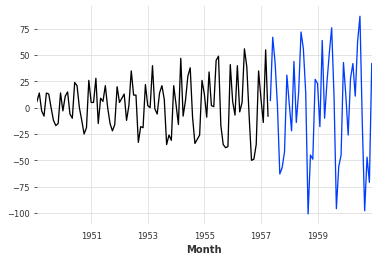

In [2]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
ts_data = TimeSeries.from_dataframe(df, 'Month')
ts_data = ts_data.diff(1)
ts_train, ts_val = ts_data.split_before(0.7)
ts_train.plot()
ts_val.plot()

Next we need to decide for a model. As you might have guessed from the title we are going to use a regression model. The `RegressionModel` itself has three parameters:

- lags: Number or indices of lagged values of the target series. Must be a strictly positive integer or a list of strictly positive integers. For example `lags=12` means that you want to predict `y(t)` with `y(t-1)`, `y(t-2)`, ..., `y(t-12)`. Another example would be `lags=[1, 4, 8, 12]` which would predict `y(t)` with `y(t-1)`, `y(t-4)`, `y(t-8)` and `y(t-12)`.
- lags_exog: Number or indices of lagged values of the exogenous series. Must be a positive integer or a list of positive integers (including 0). For example if you have two exogenous variables X1 and X2, then `lags=12` aims to predict `y(t)` with `X1(t-1)`, `X1(t-2)`, ..., `X1(t-12)` and `X2(t-1)`, `X2(t-2)`, ..., `X2(t-12)`. Another example would be `lags=[0, 1, 4, 8, 12]` which would predict `y(t)` with `X1(t)`, `X1(t-1)`, `X1(t-4)`, `X1(t-8)` and `X1(t-12)` as well as `X2(t)`, `X2(t-1)`, `X2(t-4)`, `X2(t-8)` and `X2(t-12)`. Note that `lags_exog=[0]` (or euqivalently `lags_exog=0`) would result in a standard linear regression model without lags. 
- model: By default the `RegressionModel` is going to use `darts.models.StandardRegressionModel` which is a wrapper around [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), but you can use any model exposing the `fit(X, y)` and `predict(X)` methods, where X are the exogenous covariates and y is the target series (the parameter names do not need to be "X" and "y", but they need to be specified in that order).

In this case we don't have any exogenous variables so we ignore the `lags_exog` parameter (default: `None`) but use the previous 12 month to predict the next time point. We use this model to fit the data and subsequently predict the validation data set.

In [3]:
def fit_and_predict(regression_model=None):
    regression_model.fit(ts_train)
    ts_pred = regression_model.predict(n=len(ts_val))
    reg_model_rmse = rmse(ts_pred, ts_val)

    ts_train.plot(label="Train")
    ts_val.plot(label="Test")
    ts_pred.plot(label="Prediction")
    
    plt.title("RMSE: {}".format(reg_model_rmse))
    plt.legend()

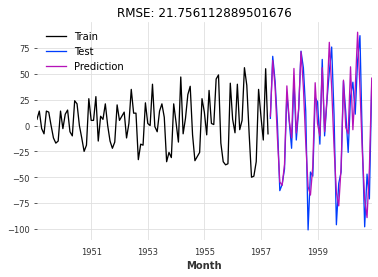

In [4]:
model_lin = RegressionModel(lags=12) # equivalent to `LinearRegressionModel(lags=12)`
fit_and_predict(regression_model=model_lin)

Not too bad for a first try, but maybe we can do better. `darts` makes it very easy to exchange this model with, for example, a random forest. 

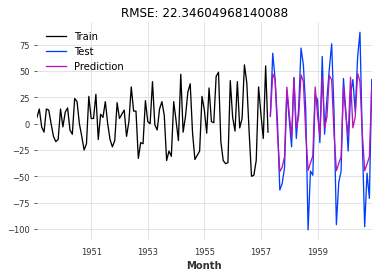

In [5]:
model_rf = RandomForest(lags=12) 
# `RegressionModel(lags=12, model=RandomForestRegressor())` equivalent, with sklearn model
# `RegressionModel(lags=12, model=RandomForest(lags_exog=0))` equivalent with the same darts model
fit_and_predict(regression_model=model_rf)

It's not really better due to the aforementioned problem of prediction to the mean for Random Forests.
Let's now use a model which is not yet implemented. We use `sklearn.linear_model.HuberRegressor` which uses the Huber loss which makes it more robust to outliers. This is not really of big use here but it shows how easy new models can be used.

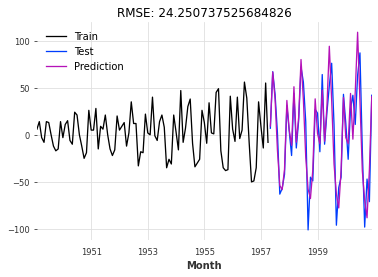

In [6]:
model_huber = RegressionModel(lags=12, model=HuberRegressor())
fit_and_predict(regression_model=model_huber)

### Load data with exogenous variables

Next we will look at an example with exogenous covariates. This means we have one target time series we try to predict and another time series which might help us to predict the target. Again we try to reduce the influence of any trend and create a training and testing data set.

            heater  ice cream
Month                        
2004-02-01    -9.0        2.0
2004-03-01    -4.0        1.0
2004-04-01    -1.0        3.0
2004-05-01     0.0        2.0
2004-06-01     0.0        3.0
Freq: MS


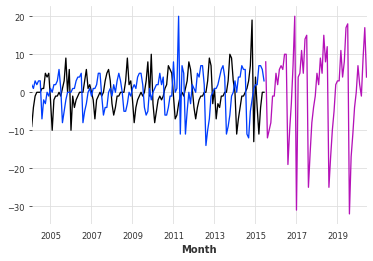

In [7]:
df = pd.read_csv('ice_cream_heater.csv', delimiter=",")
ts_data_exog = TimeSeries.from_dataframe(df, 'Month')
ts_data_exog = ts_data_exog.diff(1)
print(ts_data_exog[:5])
ts_train_exog, ts_val_exog = ts_data_exog.split_before(0.7)
ts_train_exog["heater"].plot(label="heater")
ts_train_exog["ice cream"].plot(label="ice cream")
ts_val_exog["ice cream"].plot()

First let's quickly fit a model without exogenous variables to see if the covariate adds any more information.

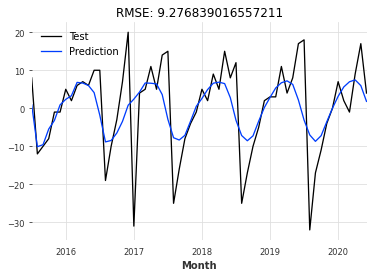

In [8]:
regression_model = RegressionModel(lags=12)
regression_model.fit(ts_train_exog["ice cream"])
ts_pred_exog = regression_model.predict(n=len(ts_val_exog["ice cream"]))
reg_model_rmse = rmse(ts_pred_exog, ts_val_exog["ice cream"])

ts_val_exog["ice cream"].plot(label="Test")
ts_pred_exog.plot(label="Prediction")

plt.title("RMSE: {}".format(reg_model_rmse))
plt.legend()

Now add the information of exogenous variables and compare different models.

In [9]:
def fit_and_predict_exog(regression_model=None):
    regression_model.fit(series=ts_train_exog["ice cream"], exog=ts_train_exog["heater"])
    ts_pred_exog = regression_model.predict(n=len(ts_val_exog), exog=ts_val_exog["heater"])
    reg_model_rmse = rmse(ts_pred_exog, ts_val_exog["ice cream"])

    ts_val_exog["ice cream"].plot(label="Test")
    ts_pred_exog.plot(label="Prediction")
    
    plt.title("RMSE: {}".format(reg_model_rmse))
    plt.legend()

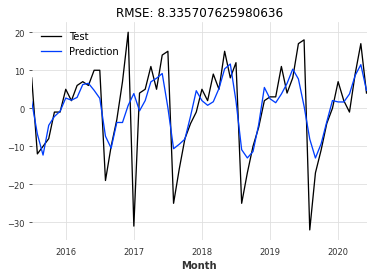

In [10]:
model_lin_exog = RegressionModel(lags=12, lags_exog=12) 
fit_and_predict_exog(regression_model=model_lin_exog)

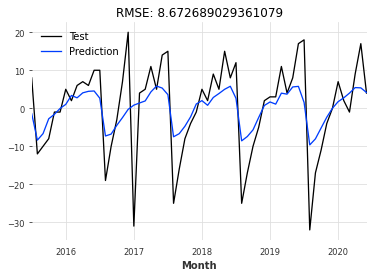

In [11]:
model_rf_exog = RandomForest(lags=12, lags_exog=12) 
fit_and_predict_exog(regression_model=model_rf_exog)

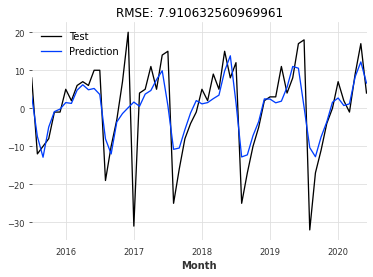

In [12]:
model_huber_exog = RegressionModel(lags=12, lags_exog=12, model=HuberRegressor()) 
fit_and_predict_exog(regression_model=model_huber_exog)